# Long-range entanglement with limited qubit connectivity [Abstracted Version]

This tutorial is based on the IBM Quantum Learning tutorial, "[Long-range entanglement with dynamic circuits
](https://quantum.cloud.ibm.com/docs/en/tutorials/long-range-entanglement#long-range-entanglement-with-dynamic-circuits)". It covers the core idea from the original: using a **measurement-based implementation with dynamic circuits** to entangle qubits, which helps optimize QPU (Quantum Processing Unit) usage. 

This notebook aims to provide a starting point for the Lab 1 open challenge by demonstrating how to create long-range entanglement between physically non-directly connected qubits. The ideas and results presented build upon the work in the paper by Elisa Bäumer et al. [1]. You can find a more high level explanation in [this blog post.](https://www.ibm.com/quantum/blog/long-range-entanglement)

Usage estimate: ~30 seconds on ibm_torino. (NOTE: This is an estimate only. Your runtime may vary.)

<div class="alert alert-block alert-warning">
<b>Resource limit</b>

The original tutorial consumes roughly 90 min QPU time accordingly. Please use this tutorial to save your resource.

</div>

## Requirements

Before starting this tutorial, ensure that you have the following installed:


In [ ]:
!pip install -U 'qiskit[visualization]' matplotlib numpy qiskit-ibm-runtime

In this tutorial, you will run a gate teleportation circuit in three different setups. We will always assume a line of n qubits, where we want to apply a CNOT gate between the two end qubits, with n-2 ancilla qubits in between.

The three approaches are:
* **Unitary-based implementation**: This method uses SWAP gates to bring the qubits to the middle to apply the CNOT.
* **Measurement-based implementation (with dynamic circuits)**: This method uses measurement and real-time feedforward of information during the quantum computation.

As a starting point for this extrachallenge, this notebook will demonstrate the implementation of a Bell state between the qubit pairs **[0,1]**, **[0,3]**, and **[0,15]** of an Eagle processor in the two given ways and compare the results.

### Import Necessary Libraries
Before we begin, we need to import the main functions from Qiskit.

In [1]:
import os

import numpy as np
from numpy import pi
import matplotlib.pyplot as plt


# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.primitives import BitArray
from qiskit.visualization import *

from qiskit_ibm_runtime import QiskitRuntimeService

from qiskit.circuit import Gate
from qiskit.circuit.library import XGate

from qiskit.providers.backend import BackendV2 as Backend
from qiskit.transpiler import CouplingMap, InstructionDurations
from qiskit.transpiler.passmanager import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService, Options
from qiskit_ibm_runtime import Session, Batch, SamplerV2 as Sampler

from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    DynamicCircuitInstructionDurations,
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

### Set Up and Prepare the IBM Quantum Backend

To run circuits on a real quantum computer, we first connect to the IBM Quantum service using `QiskitRuntimeService`. Then, from the available backends, we select the specific hardware we will use for this experiment.

Here, we will select least busy 127-qubit Eagle processor, as our backend.

In [4]:
# Save your API token to track your progress and have access to the quantum computers

#your_token="your_token"
#your_instace="your_crn"

QiskitRuntimeService.save_account(
    channel="ibm_cloud",
    token="your_token",
    instance="your_crn",
    set_as_default=True,
    overwrite=True,
)

In [5]:
from qiskit_ibm_runtime import QiskitRuntimeService
from typing import Any, List, Dict, Union, Optional, Callable, Tuple
from qiskit.circuit import IfElseOp

service = QiskitRuntimeService()


### **Set Primary Parameters**

In this section, we define some common parameters that will be used throughout the experiment. These parameters need to be configured for a particular backend. For instance, the **`COUPLING_MAP`** defines the physical connectivity between qubits, which determines where two-qubit gates like CNOT can be applied.

Here, we will filter the full `COUPLING_MAP` to create a linear map, `COUPLING_MAP_1D`, which only includes the connections along our specified `QUBIT_LINE`.


In [6]:
def coupling_map_from_qubit_line(coupling_map:List[List[int]],
                                 qubit_line: List[List[int]]) -> List[List[int]]:
    """
     Modify the full coupling map to force linearity in the qubit layout
    """
    new_coupling_map = []
    line_edge_list = []
    for i in range(len(qubit_line)-1):
        line_edge_list.append([qubit_line[i],qubit_line[i+1]])

    for edge in coupling_map:
        u,v = edge
        edge_rev = [v,u]
        if (edge in line_edge_list) or (edge_rev in line_edge_list):
            new_coupling_map.append(edge)
    return new_coupling_map


# Set which quantum computer to use
backend = service.least_busy(operational=True)
backend.target.add_instruction(IfElseOp, name="if_else")

MACHINE_NAME = backend.name

#update qubit line according to your backend connectivity, here I used ibm_torino
qubit_lines = {backend.name:[0,1,2,3,4,16,23, 24, 25, 35, 44]}

# Set qubit line and coupling map
QUBIT_LINE = qubit_lines[MACHINE_NAME]
COUPLING_MAP_FULL = [list(edge) for edge in list(QiskitRuntimeService().backend(MACHINE_NAME).coupling_map)]
COUPLING_MAP_1D = coupling_map_from_qubit_line(COUPLING_MAP_FULL, QUBIT_LINE)
MAX_POSSIBLE_QUBITS_BTW_CNOT = len(QUBIT_LINE) - 2


print(f"Machine is set to: {MACHINE_NAME}")
print(f"Maximum number of qubits between CNOT for {MACHINE_NAME} is {MAX_POSSIBLE_QUBITS_BTW_CNOT} with the given qubit line.")

Machine is set to: ibm_torino
Maximum number of qubits between CNOT for ibm_torino is 9 with the given qubit line.


In [7]:
OPTIMIZATION_LEVEL = 3
# Set to True to use dynamical decoupling
SHOTS = 1024
sampler = Sampler(mode=backend)
sampler.options.experimental = {"execution_path" : "gen3-experimental"}

### Prepare for Dynamic Decoupling

During a quantum computation, qubits in an idle state (waiting for their next operation) are susceptible to losing their quantum state due to environmental interactions (decoherence). **Dynamic Decoupling** is a technique that reduces the impact of this noise by applying a specific sequence of pulses (here, two X-gates) to the idle qubits, improving overall fidelity.

We will prepare to apply this using the `PadDynamicalDecoupling` pass.

In [8]:
from qiskit_ibm_runtime.transpiler.passes.scheduling import (
    ASAPScheduleAnalysis,
    PadDynamicalDecoupling,
)
from qiskit.circuit.library import XGate
durations = backend.target.durations()

# This is the sequence we'll apply to idling qubits
dd_sequence = [XGate(), XGate()]

# Run scheduling and dynamic decoupling passes on circuit
pm_dd = PassManager([ASAPScheduleAnalysis(durations), PadDynamicalDecoupling(durations, dd_sequence)])

#### Unitary-based implementation swapping the qubits to the middle

First, examine the case where a long-range CNOT gate is implemented using nearest-neighbor connections and unitary gates. In the following figure, on the left is a circuit for a long-range CNOT gate spanning a 1D chain of n-qubits subject to nearest-neighbor connections only. On the right is an equivalent unitary decomposition implementable with local CNOT gates, circuit depth O(n).

![image.png](https://learning-api.quantum.ibm.com/assets/19afd12f-2ba1-4d1e-9ac7-4801b8049a64)

The circuit on the right can be implemented as follows:


In [9]:
def CNOT_unitary(qc: QuantumCircuit, control_qubit: int, target_qubit: int) -> QuantumCircuit:
    """Generate a CNOT gate bewteen data qubit control_qubit and data qubit target_qubit using local CNOTs

    Assumes that the long-range CNOT gate will be spanning a 1D chain of n-qubits subject to nearest-neighbor
    connections only with the chain starting at the control qubit and finishing at the target qubit.

    Assumes that control_qubit < target_qubit (as integers) and that the provided circuit qc has |0> set
    qubits control_qubit+1, ..., target_qubit-1

    Args:
        qc (QuantumCicruit) : A Quantum Circuit to add the long range localized unitary CNOT
        control_qubit (int) : The qubit used as the control.
        target_qubi (int) : The qubit targeted by the gate.

    Example:

        qc = QuantumCircuit(8,2)
        qc = CNOT_unitary(qc, 0, 7)

    Returns:
        QuantumCircuit

    """
    assert target_qubit > control_qubit
    n = target_qubit - control_qubit - 1
    k = int(n/2)
    qc.barrier()
    for i in range(control_qubit, control_qubit + k):
        qc.cx(i,i+1)
        qc.cx(i+1,i)
        qc.cx(-i-1,-i-2)
        qc.cx(-i-2,-i-1)
    if n%2==1:
        qc.cx(k+2,k+1)
        qc.cx(k+1,k+2)
    qc.barrier()
    qc.cx(k,k+1)
    for i in range(control_qubit, control_qubit + k):
        qc.cx(k-i,k-1-i)
        qc.cx(k-1-i,k-i)
        qc.cx(k+i+1,k+i+2)
        qc.cx(k+i+2,k+i+1)
    if n%2==1:
        qc.cx(-2,-1)
        qc.cx(-1,-2)
    qc.barrier()
    return qc

#### Long-range measurement-based CNOT with feedforward

Finally, examine the case where a long-range CNOT gate is implemented using measurement-based CNOT with feedforward (dynamic circuits). In the following figure, on the left is a circuit for a long-range CNOT gate spanning a 1D chain of n-qubits subject to nearest-neighbor connections only. On the right is an equivalent implementable with local CNOT gates, measurement-based CNOT with feedforward (dynamic circuits).

![image.png](https://learning-api.quantum.ibm.com/assets/a1d03a10-bca6-45aa-a80b-d6ba85a88408)

The circuit on the right can be implemented as follows:

In [10]:
from qiskit.circuit.classical import expr

def CNOT_dyn(qc: QuantumCircuit,
             control_qubit: int,
             target_qubit: int,
             c1: Optional[ClassicalRegister]=None,
             c2: Optional[ClassicalRegister]=None,
             add_barriers: Optional[bool]=True) -> QuantumCircuit:
    """Generate a CNOT gate bewteen data qubit control_qubit and data qubit target_qubit using Bell Pairs.

    Post processing is used to enable the CNOT gate via the provided classicial registers c1 and c2

    Assumes that the long-range CNOT gate will be spanning a 1D chain of n-qubits subject to nearest-neighbor
    connections only with the chain starting at the control qubit and finishing at the target qubit.

    Assumes that control_qubit < target_qubit (as integers) and that the provided circuit qc has |0> set
    qubits control_qubit+1, ..., target_qubit-1

    n = target_qubit - control_qubit - 1 : Number of qubits between the target and control qubits
    k = int(n/2) : Number of Bell pairs created

    Args:
        qc (QuantumCicruit) : A Quantum Circuit to add the long range localized unitary CNOT
        control_qubit (int) : The qubit used as the control.
        target_qubi (int) : The qubit targeted by the gate.

    Optional Args:
        c1 (ClassicialRegister) : Default = None. Required if n > 1. Register requires k bits
        c2 (ClassicalRegister) : Default = None. Required if n > 0. Register requires n - k bits
        add_barriers (bool) : Default = True. Include barriers before and after long range CNOT

    Note: This approached uses two if_test statements. A better (more performant) approach is
    to have the parity values combined into a single classicial register and then use a switch
    statement. This was done in the associated paper my modifying the qasm file directly. The ability
    to use a switch statement via Qiakit in this way is a future release capability.

    Returns:
        QuantumCircuit
    """
    assert target_qubit > control_qubit
    n = target_qubit - control_qubit - 1
    t = int(n/2)

    if add_barriers is True:
        qc.barrier()

    # Deteremine where to start the bell pairs and
    # add an extra CNOT when n is odd
    if n%2 == 0:
        x0 = 1
    else:
        x0 = 2
        qc.cx(0,1)

    # Create t Bell pairs
    for i in range(t):
        qc.h(x0+2*i)
        qc.cx(x0+2*i,x0+2*i+1)

    # Entangle Bell pairs and data qubits and measure
    for i in range(t+1):
        qc.cx(x0-1+2*i,x0+2*i)

    for i in range(1,t+x0):
        if (i==1):
            qc.h(2*i+1-x0)
            qc.measure(2*i+1-x0, c2[i-1])
            parity_control = expr.lift(c2[i-1])
        else:
            qc.h(2*i+1-x0)
            qc.measure(2*i+1-x0, c2[i-1])
            parity_control = expr.bit_xor(c2[i-1], parity_control)

    for i in range(t):
        if (i==0):
            qc.measure(2*i+x0, c1[i])
            parity_target = expr.lift(c1[i])
        else:
            qc.measure(2*i+x0, c1[i])
            parity_target = expr.bit_xor(c1[i], parity_target)

    if (n>0):
        with qc.if_test(parity_control):
            qc.z(0)

    if (n>1):
        with qc.if_test(parity_target):
            qc.x(-1)

    if add_barriers is True:
        qc.barrier()
    return qc

### **Create the Experiment Circuits**

Now, we will create the circuits for our experiment using the three methods defined above (`CNOT_unitary`, `CNOT_dyn`) and a reference circuit with a direct CNOT. We will create circuits for the **[0,3]** and **[0,16]** qubit pairs to compare performance over different distances.

We use `generate_preset_pass_manager` to optimize (transpile) each circuit for the backend's specific qubit layout and coupling map. Finally, we apply dynamic decoupling by running them through `pm_dd.run`.

All circuits will be saved into `circuits`.

In [12]:
# Reference Circuit (0 & 1)
circuits = []
layout = QUBIT_LINE[:2]
pm = generate_preset_pass_manager(coupling_map = COUPLING_MAP_1D,
                                    initial_layout = layout,
                                    optimization_level = 3,
                                    backend = backend)

qr = QuantumRegister(2, name="q")         # Circuit with n qubits between control and target
cr = ClassicalRegister(2, name="cr")

ref_circ = QuantumCircuit(qr,cr)
ref_circ.h(0)
ref_circ.cx(0,1)
ref_circ.measure(qr,cr)
circuits.append(pm_dd.run(pm.run(ref_circ)))

In [13]:
#[0,3]
n=2
layout = QUBIT_LINE[:n+2]

qr = QuantumRegister(n+2, name="q")         # Circuit with n qubits between control and target
cr = ClassicalRegister(2, name="cr")        # Classicial register for measuring long range CNOT

k = int(n/2)                                # Number of Bell States to be used
c1 = ClassicalRegister(k,   name="c1")
c2 = ClassicalRegister(n-k, name="c2")      # Classicial register needed for post processing

pm = generate_preset_pass_manager(coupling_map = COUPLING_MAP_1D,
                                    initial_layout = layout,
                                    optimization_level = 3,
                                    backend = backend)

#pm.scheduling = PassManager(
#    [
#        ALAPScheduleAnalysis(durations),
#        PadDynamicalDecoupling(durations, dd_sequence),
#    ]
#)
    
circuit = QuantumCircuit(qr, cr, c1,c2, name="CNOT")
circuit.h(0)
circuit = CNOT_unitary(circuit,0,3,)
circuit.measure([0,3],[0,1])
circuits.append(pm_dd.run(pm.run(circuit)))


circuit = QuantumCircuit(qr, cr, c1,c2, name="CNOT")
circuit.h(0)
circuit = CNOT_dyn(circuit,0,3,c1,c2)
circuit.measure([0,3],cr)
circuits.append(pm_dd.run(pm.run(circuit)))

In [23]:
#[0,15]

n=4
layout = QUBIT_LINE[:n+2]

qr = QuantumRegister(n+2, name="q")         # Circuit with n qubits between control and target
cr = ClassicalRegister(2, name="cr")        # Classicial register for measuring long range CNOT

k = int(n/2)                                # Number of Bell States to be used
c1 = ClassicalRegister(k,   name="c1")
c2 = ClassicalRegister(n-k, name="c2")      # Classicial register needed for post processing

pm = generate_preset_pass_manager(coupling_map = COUPLING_MAP_1D,
                                    initial_layout = layout,
                                    optimization_level = 3,
                                    backend = backend)
circuit = QuantumCircuit(qr, cr, c1,c2, name="CNOT")
circuit.h(0)
circuit = CNOT_unitary(circuit,0,n+1)
circuit.measure([0,n+1],cr)
circuits.append(pm_dd.run(pm.run(circuit)))


circuit = QuantumCircuit(qr, cr, c1,c2, name="CNOT")
circuit.h(0)
circuit = CNOT_dyn(circuit,0,n+1,c1,c2)
circuit.measure([0,n+1],cr)
circuits.append(pm_dd.run(pm.run(circuit)))

### Execute using Qiskit Primitives

All the prepared circuits are now executed on the backend using the `Sampler` primitive. The `Sampler` is responsible for running circuits and returning the measurement outcomes as a probability distribution.

Using a `Session` context manager allows us to efficiently group and manage multiple jobs. Each circuit will be run for **1024 shots** to gather reliable statistics.



In [14]:
job_ids = []


job = sampler.run(circuits, shots=1024)

job_id = job.job_id()

In [ ]:
job.status()

In [35]:
from qiskit_ibm_runtime import QiskitRuntimeService
job = service.job(job_id)
job_result = job.result()

### Analyze and Visualize the Results

Once the job is complete, we retrieve the measurement `counts` from the results of each circuit.

Using `plot_histogram`, we can visualize and compare the results for each method (Unitary, Dynamic) and distance ([0,1], [0,3], [0,15]) in a single histogram. For an ideal Bell state, we expect to measure the `00` and `11` states with roughly 50% probability each. The histogram allows us to see how close each method came to this ideal outcome in a noisy environment.

In [36]:
counts = []
for result in job_result:
    counts.append(result.data.cr.get_counts())

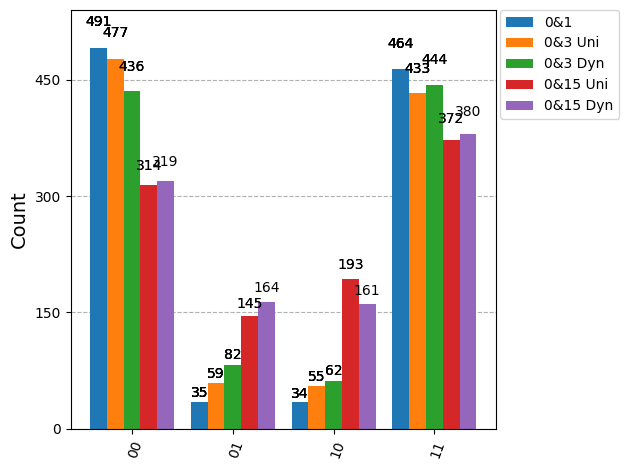

In [37]:
from qiskit.visualization import plot_histogram

plot_histogram(counts, legend=['0&1', '0&3 Uni', '0&3 Dyn', '0&15 Uni', '0&15 Dyn'])

## References

[1] Efficient Long-Range Entanglement using Dynamic Circuits, by
*Elisa Bäumer, Vinay Tripathi, Derek S. Wang, Patrick Rall, Edward H. Chen, Swarnadeep Majumder, Alireza Seif, Zlatko K. Minev*. IBM Quantum, (2023).
https://arxiv.org/abs/2308.13065
